# MBTA Communities interim compliance

From this MBTA Communties [page](https://www.mass.gov/info-details/multi-family-zoning-requirement-for-mbta-communities):

<em>
Interim Compliance – Action Plan
An MBTA community that does not have zoning in place that complies with Section 3A must take active steps towards achieving compliance in order to remain eligible for certain annual funding rounds.  The Guidelines allow communities to create and complete an online Action Plan form that outlines the municipality’s process for adopting compliant zoning. When DHCD approves the Action Plan, then the community will achieve “interim compliance” and will retain eligibility for the funding sources that require compliance with Section 3A.

To remain eligible for the calendar year 2023 round of MassWorks and Housing Choice grants, as well as the Local Capital Projects Fund, an MBTA community must submit an Action Plan no later than January 31, 2023. 
No MBTA community may remain in interim compliance after its district compliance deadline has passed.
A copy of the Action Plan form and access to the online Action Plan form are available below
</em>

Waltham submitted their interim plans on time, however as of 2023/03/04 (see *Action Plan Submission Statuses* on that page) we still haven't been approved. Even after we're approved,
the city needs to relax zoning codes so that sufficient MFH housing is allowed 'by right'.

In [2]:
from dvc.api import DVCFileSystem
import pandas as pd
from io import BytesIO
from zipfile import ZipFile
import geopandas as geo_pd
from dbfread import DBF

fs = DVCFileSystem("https://github.com/tjrileywisc/waltham_etl")


In [3]:

# mbta required
MANDATE_REQD = 3_982

MFH_CITYWIDE = 15_294

# claimed by mayor's office
CARTER_ST_CLAIMED = 5_008
BRANDEIS_CLAIMED = 540

SFH_CODE = "101"

# use codes counted as MFH
MFH_CODES = [
    "112",
    "013",
    "031",
    "043",
    "125",
    "111",
    "109",
    "908",
    "121",
    "105",
    "104",
    "014",
    "041",
    "102",
    "905",
    "920"
]

## Load current zoning and DHCD detail map for Waltham

In [4]:
with fs.open("data/mbta_communities/308_WALTHAM_detail.zip") as f:
    content = BytesIO(f.read())
    zip = ZipFile(content)
    zip.extractall("../../data/mbta_communities/308_WALTHAM_detail")
    property_shapefiles_df = geo_pd.read_file("../../data/mbta_communities/308_WALTHAM_detail/308_WALTHAM_detail.shp")
    
property_shapefiles_df.drop(axis="columns", labels=["Owner"], inplace=True)

property_shapefiles_df["UseCodes"] = property_shapefiles_df["UseCodes"].astype(str)
property_shapefiles_df.head()

,LOC_ID,Address,UseCodes,UseDesc,TRANSIT,ACRES,SQFT,PublicInst,NonPubExc,Tot_Exclud,...,Wetlands,TitleV,Wellhead1,Flood_SHFA,Farmland,SurfWatBC,Wellhead2,IntWellhea,Habitat,geometry
0,F_720576_2954833,"726 SOUTH ST, SOUTH ST, WALTHAM, 02453",903,(formerly Municipalities/Districts. Removed J...,Y,0.268435,11693.049406,11693.792788,2343.604743,11693.792788,...,0.000000,2286.888339,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,"POLYGON ((219693.364 900605.105, 219632.899 90..."
1,F_722539_2954565,"167 EDGEWATER DR, EDGEWATER DR, WALTHAM, 02453",101,Single Family Residential,N,3.760119,163790.789897,0.000000,112055.168152,112055.168152,...,90234.398162,19056.802159,0.0,119268.637810,0.0,0.0,0.0,0.0,0.0,"POLYGON ((220199.657 900534.011, 220212.276 90..."
2,F_722274_2954887,"105 EDGEWATER DR, EDGEWATER DR, WALTHAM, 02453",101,Single Family Residential,Y,0.552854,24082.340199,0.000000,906.091999,906.090355,...,23.357678,906.091999,0.0,2650.988149,0.0,0.0,0.0,0.0,0.0,"POLYGON ((220183.593 900647.010, 220142.145 90..."
3,F_722477_2954895,"44 RIVERSIDE DR, RIVERSIDE DR, WALTHAM, 02453",101,Single Family Residential,Y,0.347326,15129.509686,0.000000,3468.070430,3468.070430,...,0.000000,3468.070430,0.0,2245.188236,0.0,0.0,0.0,0.0,0.0,"POLYGON ((220232.880 900672.543, 220232.576 90..."
4,F_722168_2954973,"85 KNOLLWOOD DR, KNOLLWOOD DR, WALTHAM, 02453",101,Single Family Residential,Y,0.278369,12125.747026,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,"POLYGON ((220137.309 900682.421, 220131.801 90..."


In [5]:
with fs.open("data/gis/L3_SHP_M308_WALTHAM.zip") as f:
    content = BytesIO(f.read())
    zip = ZipFile(content)
    zip.extractall("../../data/gis")

    assessments_table = DBF("../../data/gis/L3_SHP_M308_WALTHAM/M308Assess_CY22_FY23.dbf", load=True)
    assessments_df = pd.DataFrame([dict(r) for r in assessments_table.records])

In [6]:
# add tax data so we can get unit counts
property_shapefiles_df = property_shapefiles_df.merge(assessments_df, on="LOC_ID", how="left")

In [7]:
with fs.open("data/mbta_communities/Transit_Station_Areas_Half_Mile_Radius.zip") as f:
    content = BytesIO(f.read())
    zip = ZipFile(content)
    zip.extractall("../../data/mbta_communities/Transit_Station_Areas_Half_Mile_Radius")
    half_mile_radius_df = geo_pd.read_file("../../data/mbta_communities/Transit_Station_Areas_Half_Mile_Radius/Transit_Station_Areas_Half_Mile_Radius.shp")
    
half_mile_radius_df.head()

,Shape_Leng,Shape_Area,geometry
0,755474.208676,3.831445e+08,"MULTIPOLYGON (((230096.267 878540.938, 230094...."


In [8]:
with fs.open("data/gis/WalthamZoning.zip") as f:
    content = BytesIO(f.read())
    zip = ZipFile(content)
    zip.extractall("../../data/gis")
    zoning_df = geo_pd.read_file("../../data/gis/WalthamZoning/WalthamZoning.shp")

zoning_df.head()

,NAME,CODE,SHAPE_LENG,ORDINANCE,EDITOR,CHANGE_DAT,SOURCE,PLAN_NAME,SHAPE_STAr,SHAPE_STLe,SHAPE_ST_1,SHAPE_ST_2,geometry
0,RA2,0.0,10403.755604,NaN,NaN,NaN,NaN,NaN,4.947813e+06,10665.871058,4.947813e+06,10665.871058,"POLYGON ((721768.987 2978536.268, 721531.026 2..."
1,LC,0.0,9788.055753,NaN,NaN,NaN,NaN,NaN,3.920774e+06,9988.000732,3.920774e+06,9988.000731,"POLYGON ((720906.326 2976768.894, 720915.741 2..."
2,RA1,0.0,26764.481489,NaN,NaN,NaN,NaN,NaN,2.775205e+07,26837.486309,2.775205e+07,26837.486309,"POLYGON ((721454.447 2974595.520, 721412.905 2..."
3,RA2,0.0,1923.268768,NaN,NaN,NaN,NaN,NaN,1.400867e+05,1923.723533,1.400867e+05,1923.723533,"POLYGON ((720906.326 2976768.894, 721419.686 2..."
4,RA2,0.0,1492.657537,NaN,NaN,NaN,NaN,NaN,3.078289e+04,1492.654782,3.078289e+04,1492.654783,"POLYGON ((728482.999 2975562.250, 728502.063 2..."


In [9]:
# set the waltham zoning crs to match the MassGIS one
zoning_df.to_crs(property_shapefiles_df.crs, inplace=True)

In [10]:
# assign existing parcels to zones
property_shapefiles_df["parcel_geometry"] = property_shapefiles_df["geometry"]
property_shapefiles_df["geometry"] = property_shapefiles_df.centroid
properties_df = property_shapefiles_df.sjoin(zoning_df, how="left", predicate="within")
properties_df.drop(axis="columns", labels=["index_right", "geometry"], inplace=True)

properties_df.rename(columns={"NAME": "ZONE", "parcel_geometry": "geometry"}, inplace=True)

In [11]:
# parcels within the 0.5 mi radius of stations (assuming intersecting is allowed)
grouped = properties_df.sjoin(half_mile_radius_df, how="left").groupby("index_right")

# (there's only one MULTIPOLYGON geometry to group to)
group_id, group_df = list(grouped)[0]

# count of zoning types for parcels within station radii
group_df.ZONE.value_counts()

RB     758
RC     713
C      342
RA3    281
BC     264
RA4    149
BA      90
BB      74
CR      16
I        7
RA2      5
RA1      1
Name: ZONE, dtype: int64

In [12]:
# count of use code types
group_df.UseCodes.value_counts()

102         697
101         539
104         409
111         229
105         102
112          70
013          54
325          51
903          48
340          47
337          31
904          29
332          26
401          25
445          22
327          21
906          21
400          21
901          21
905          20
031          20
316          18
327, 102     14
121          14
326          13
132          13
109          13
343          11
343, 102     11
908          10
102, 327      9
130           8
102, 343      7
390           6
131           6
391           6
333           5
341           4
402           3
920           3
392           3
106           2
330           2
334           2
109, 131      2
014           2
322           2
324           1
410           1
430           1
404           1
440           1
900           1
362           1
335           1
039           1
424           1
342           1
Name: UseCodes, dtype: int64

In [13]:
# SFH (code 101) + MFH (see above) near transit
group_df[group_df["UseCodes"].isin(MFH_CODES + [SFH_CODE])].UseCodes.value_counts()

102    697
101    539
104    409
111    229
105    102
112     70
013     54
905     20
031     20
121     14
109     13
908     10
920      3
014      2
Name: UseCodes, dtype: int64

In [14]:
# of actual MFH homes, total unit counts
group_df[group_df["UseCodes"].isin(MFH_CODES)]["UNITS"].sum()

6360.0

## Remove units that are not qualitifed

From [the MBTA communities page](https://www.mass.gov/info-details/multi-family-zoning-requirement-for-mbta-communities):

The requirement is codified as Section 3A of MGL c. 40A:

Section 3A. (a)(1) An MBTA community shall have a zoning ordinance or by-law that provides for at least 1 district of reasonable size in which multi-family housing is permitted as of right; provided, however, that such multi-family housing shall be without age restrictions and shall be suitable for families with children. For the purposes of this section, a district of reasonable size shall: (i) have a minimum gross density of 15 units per acre, subject to any further limitations imposed by section 40 of chapter 131 and title 5 of the state environmental code established pursuant to section 13 of chapter 21A; and (ii) be located not more than 0.5 miles from a commuter rail station, subway station, ferry terminal or bus station, if applicable.

<Axes: >

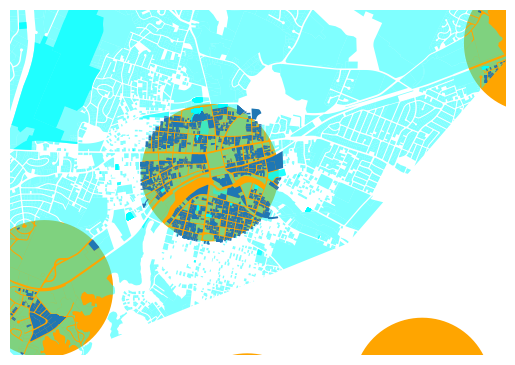

In [52]:
excluded_properties = []

# show MFH homes
mfh_homes_df = group_df[group_df["UseCodes"].isin(MFH_CODES)]

base = mfh_homes_df.plot(label="MFH homes")
base.set_axis_off()

xlim = ([mfh_homes_df.total_bounds[0],  mfh_homes_df.total_bounds[2]])
ylim = ([mfh_homes_df.total_bounds[1],  mfh_homes_df.total_bounds[3]])

base.set_xlim(xlim)
base.set_ylim(ylim)

half_mile_radius_df.plot(ax=base, zorder=-100, color="orange", label="Zoning radius")

properties_df[~properties_df["UseCodes"].isin(MFH_CODES)].plot(ax=base, zorder = -50, color="cyan", alpha=0.5, label="Other properties")

In [54]:
mfh_homes_df.sort_values(by=["UNITS"], ascending=False)[["Address", "UNITS"]].head(20)

,Address,UNITS
4050,"211 -45 MOODY ST, MOODY ST, WALTHAM, 02453",290.0
12701,"1 MOODY ST, MOODY ST, WALTHAM, 02453",269.0
4026,"20 COOPER ST, COOPER ST, WALTHAM, 02453",264.0
461,"190 MOODY ST, MOODY ST, WALTHAM, 02453",150.0
3683,"48 PINE ST, PINE ST, WALTHAM, 02453",120.0
4591,"174 MOODY ST, MOODY ST, WALTHAM, 02453",108.0
2309,"94 ADAMS ST, ADAMS ST, WALTHAM, 02453",92.0
7642,"78 -96 LEXINGTON ST, LEXINGTON ST, WALTHAM, 02451",70.0
8431,"97 LYMAN ST, LYMAN ST, WALTHAM, 02452",60.0
185,"5 -71 CHARLESBANK WAY, CHARLESBANK WAY, WALTHA...",60.0


190 Moody St. is excluded, since it has a 62 yrs and over age restriction.

[link](https://bostonland.com/Lowell-Mill.php)

174 Moody St. is the other part of the same community. Totally this is 258 units that don't count.

88 Lexington St (listed above as 78-96 Lexington) is excluded, it's single room apartments for seniors.
[link](https://www.maloneyproperties.com/rentals/st-mary-apartments/)

In [ ]:
excluded_properties.extend(
    ["190 MOODY ST, MOODY ST, WALTHAM, 02453", "174 MOODY ST, MOODY ST, WALTHAM, 02453", "78 -96 LEXINGTON ST, LEXINGTON ST, WALTHAM, 02451"]
)

In [56]:
counting_mf_homes = mfh_homes_df[~mfh_homes_df["Address"].isin(excluded_properties)]
counting_mf_homes["UNITS"].sum()

6360.0